Import libraries

In [ ]:
import shap
shap.initjs() #helps with the ability to display images in notebook
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
# load all DNN packages
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
df = pd.read_csv('final_data.csv')
df['affordability_ratio'] = df['affordability_ratio'].fillna(df['affordability_ratio'].mean()) # make sure response has no NAs

# get my X and Y matrices
X = df.drop(columns = ['affordability_ratio','LL95_affordability_ratio', 'UL95_affordability_ratio',
       'rse_food_afford', 'CA_RR_Affordability', 'affordability_per_person', 'affordable'])
features = X.columns
y = df['affordability_ratio']
# extract only the column names for each type
numeric_features = X.select_dtypes(include = ['number']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=307) # split the data

# make transformers for each data type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                  
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('filtering', SelectPercentile(f_regression, percentile=50))     
])

# run both through the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),      
        ('cat', categorical_transformer, categorical_features)  
    ])


In [ ]:
# need to deal with categorical
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Access the OneHotEncoder and SelectPercentile steps
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
selector = preprocessor.named_transformers_['cat'].named_steps['filtering']

# Get all one-hot encoded feature names
onehot_feature_names = onehot.get_feature_names_out(categorical_features)

# Apply the SelectPercentile mask
mask = selector.get_support()  # Boolean mask of selected features
selected_categorical_features = onehot_feature_names[mask]

final_feature_names = list(numeric_features) + list(selected_categorical_features)


KNN

In [32]:
# sample KNN Regressor
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5, weights = 'distance'))  
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(test_mse) 

0.03215652452314519


Ridge

In [25]:
ridge_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength for Ridge
}
# GridSearchCV
grid_search = GridSearchCV(ridge_pipe, 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5)
grid_search.fit(X_train, y_train)
# Results
print(f"Best Parameters: {grid_search.best_params_}") 
#Best Parameters: {'model__alpha': 0.01}
print(f"Best Cross-Validation MSE: {-grid_search.best_score_}") 
#Best Cross-Validation MSE: 0.004297668411110789

best_model = grid_search.best_estimator_
# Use the best model to predict
y_pred = best_model.predict(X_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(test_mse) # 0.06471089441531265

Best Parameters: {'model__alpha': 10}
Best Cross-Validation MSE: 0.04305610358107413
0.20152539908808112


Decision Tree

In [29]:
# make new numeric transformer since I only want to impute now
dt_numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='mean'))
])
dt_preprocessor = ColumnTransformer(
    transformers=[
        ('num', dt_numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
pipe = Pipeline(steps=[
    ('preprocessor', dt_preprocessor),
    ('model', DecisionTreeRegressor(random_state = 42))  
])

param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
#Best Parameters: {'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-grid_search.best_score_}")
# Best MSE: 0.0002527152802351291
y_pred = grid_search.predict(X_test)
test_mse = root_mean_squared_error(y_test, y_pred)
print(test_mse) # 0.06471089441531265

Best Parameters: {'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best MSE: 0.0002527152802351291
0.015771904920533927


DNN

Epoch 1/10


2024-12-10 16:07:21.251629: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5539/5539 [==============================] - 18s 3ms/step - loss: 0.0318 - mae: 0.0689 - val_loss: 0.0107 - val_mae: 0.0369
Epoch 2/10
5539/5539 [==============================] - 14s 3ms/step - loss: 0.0100 - mae: 0.0317 - val_loss: 0.0086 - val_mae: 0.0228
Epoch 3/10
5539/5539 [==============================] - 14s 3ms/step - loss: 0.0072 - mae: 0.0235 - val_loss: 0.0076 - val_mae: 0.0191
Epoch 4/10
5539/5539 [==============================] - 14s 3ms/step - loss: 0.0057 - mae: 0.0200 - val_loss: 0.0056 - val_mae: 0.0169
Epoch 5/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0047 - mae: 0.0174 - val_loss: 0.0047 - val_mae: 0.0125
Epoch 6/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0041 - mae: 0.0157 - val_loss: 0.0045 - val_mae: 0.0115
Epoch 7/10
5539/5539 [==============================] - 9s 2ms/step - loss: 0.0038 - mae: 0.0152 - val_loss: 0.0047 - val_mae: 0.0134
Epoch 8/10
5539/5539 [==============================] - 9s 2ms/step -

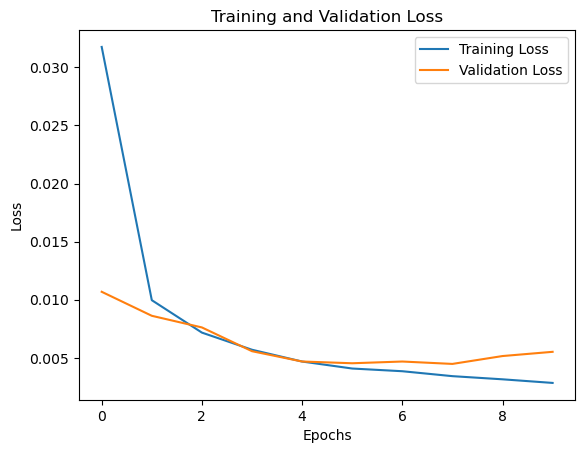

2308/2308 [==============================] - 1s 495us/step
Test rMSE: 0.06289655797499667


In [31]:
# scale features 
scaler = StandardScaler(with_mean = False) # since some features are one hot encoded
X_train_DNN = scaler.fit_transform(X_train_processed)  # Preprocessed numeric/categorical data
X_test_DNN = scaler.transform(X_test_processed)

# define neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_DNN.shape[1],)),  # Input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Another hidden layer
    Dense(1)  # Output layer for regression
])
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train the model
# implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)
# convert sparse matrix to dense
X_train_DNN_dense = X_train_DNN.toarray()
history = model.fit(
    X_train_DNN_dense, y_train,  # Use log-transformed targets if needed
    validation_split=0.2,  # Use part of the training data for validation
    epochs=10,  # Maximum number of epochs
    batch_size=32,  # Batch size for gradient updates
    callbacks=[early_stopping],  # Add early stopping
    verbose=1  # Print progress
)

# plot training and validation loss to eval model performance
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# evaluate model
# predict on test data
y_test_pred_dnn = model.predict(X_test_DNN)
rmse = root_mean_squared_error(y_test, y_test_pred_dnn)
print(f"Test rMSE: {rmse}")

XGBoost

In [5]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}
gb_grid_search = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose = 1
)
gb_grid_search.fit(X_train_processed, y_train)
print(f"Best Parameters: {gb_grid_search.best_params_}")
# Best Parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
print(f"Best MSE: {-gb_grid_search.best_score_}")
# Best MSE: 132159.55162585393
y_test_pred = gb_grid_search.predict(X_test_processed)
mse = root_mean_squared_error(y_test, y_test_pred)
print(f'Test rMSE: {mse}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best MSE: 0.00013304951024929618
Test rMSE: 0.015282375155150112


In [34]:
model = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0,
    random_state=42  
)

model.fit(X_train_processed, y_train)
y_pred_model = model.predict(X_test_processed)

mse = root_mean_squared_error(y_test, y_pred_model)
print(f'Test rMSE: {mse}')

Test rMSE: 0.015282375155150112


# SHAP

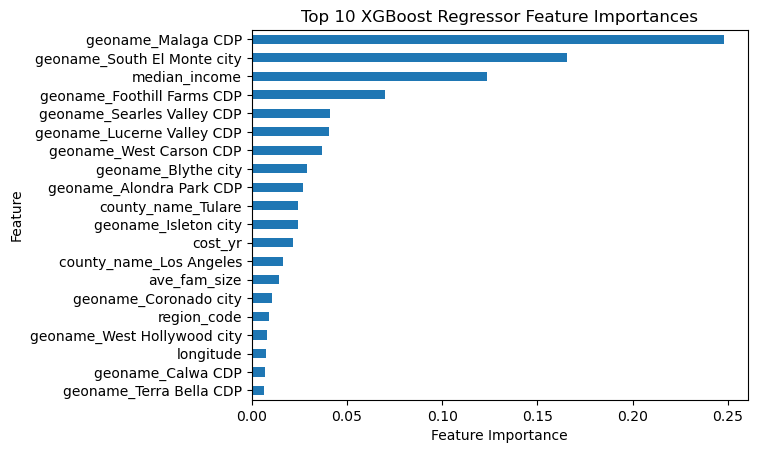

In [35]:
# Create a Series for feature importances
feature_importances = pd.Series(model.feature_importances_, index=final_feature_names)

# Select the top 10 features
top_10_features = feature_importances.nlargest(20)

# Plot the top 10 feature importances
top_10_features.plot.barh()
plt.title('Top 10 XGBoost Regressor Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

### Get Accuracy Stuff

In [ ]:
# Calculate errors
errors = y_test - y_test_pred
abs_errors = np.abs(errors)
# Define thresholds
acceptable_error = 0.01 * y_test  # Tolerance low because rMSE low and values are on log scale
large_error_threshold = 0.02 * y_test  # Significant error low for same reason
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': errors,
    'Absolute_Error': abs_errors
})
# Classify predictions
results['Category'] = np.where(
    abs_errors <= acceptable_error, 'TP/TN',  # Accurate predictions (True Positives/Negatives)
    np.where(
        errors > large_error_threshold, 'FP',  # Overprediction (False Positive)
        np.where(
            errors < -large_error_threshold, 'FN',  # Underprediction (False Negative)
            'Other'  # Cases not meeting other criteria
        )
    )
)
# True Positives/Negatives (low error within acceptable range)
tp_tn = results[results['Category'] == 'TP/TN'].head(5)
# False Positives (significant overprediction)
fp = results[results['Category'] == 'FP'].head(5)
# False Negatives (significant underprediction)
fn = results[results['Category'] == 'FN'].head(5)
print("True Positives/Negatives (TP/TN):")
print(tp_tn)
print("\nFalse Positives (FP):")
print(fp)
print("\nFalse Negatives (FN):")
print(fn)

True Positives/Negatives (TP/TN):
          Actual  Predicted         Error  Absolute_Error Category
76012   0.324716   0.324613  1.034459e-04    1.034459e-04    TP/TN
171844  0.324716   0.324606  1.105985e-04    1.105985e-04    TP/TN
38795   0.324716   0.324543  1.738688e-04    1.738688e-04    TP/TN
154986  0.324716   0.324613  1.034459e-04    1.034459e-04    TP/TN
149589  0.324716   0.324717 -8.732621e-08    8.732621e-08    TP/TN

False Positives (FP):
          Actual  Predicted     Error  Absolute_Error Category
164199  1.449142   1.340279  0.108863        0.108863       FP
232347  0.639492   0.621669  0.017823        0.017823       FP
184386  0.274815   0.259698  0.015116        0.015116       FP
95025   0.301894   0.294306  0.007589        0.007589       FP
285186  0.216425   0.211217  0.005207        0.005207       FP

False Negatives (FN):
          Actual  Predicted     Error  Absolute_Error Category
61625   0.210926   0.215238 -0.004312        0.004312       FN
46790   0.3406

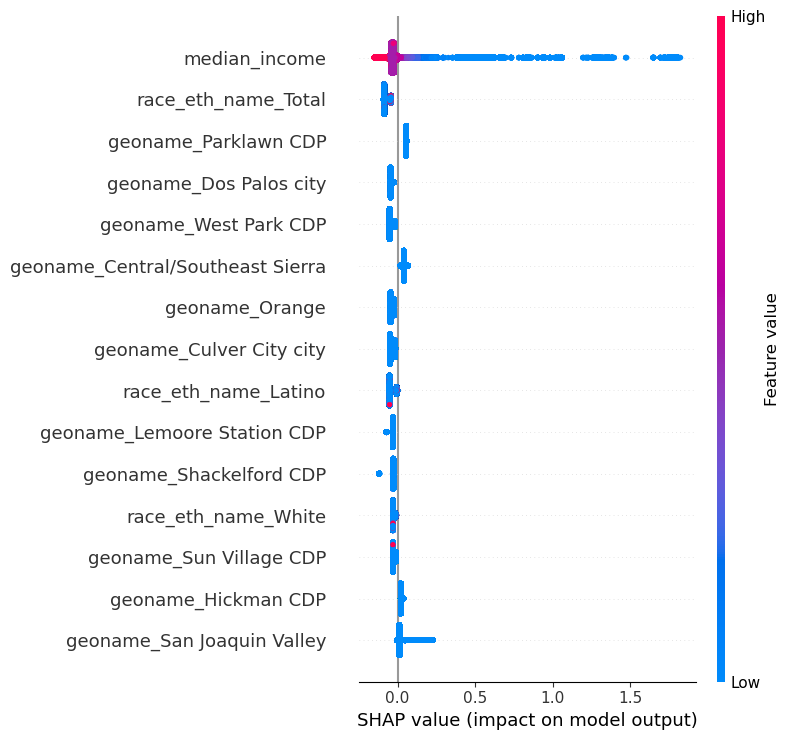

In [36]:
# create explainer for trained model
X_train_dense = X_train_processed.toarray()
X_train_dense_df = pd.DataFrame(X_train_dense, columns=final_feature_names)
# Create SHAP explainer for the model
explainer = shap.TreeExplainer(model)
# Get SHAP values
shap_values = explainer.shap_values(X_train_dense_df)
# Visualize SHAP values with feature names
shap.summary_plot(shap_values, X_train_dense_df, max_display=15)

In [37]:
# Replace 'index' with the index of the row you want to explain
shap.force_plot(explainer.expected_value[0], shap_values.values[10, :], X_train_dense[10, :])

IndexError: invalid index to scalar variable.

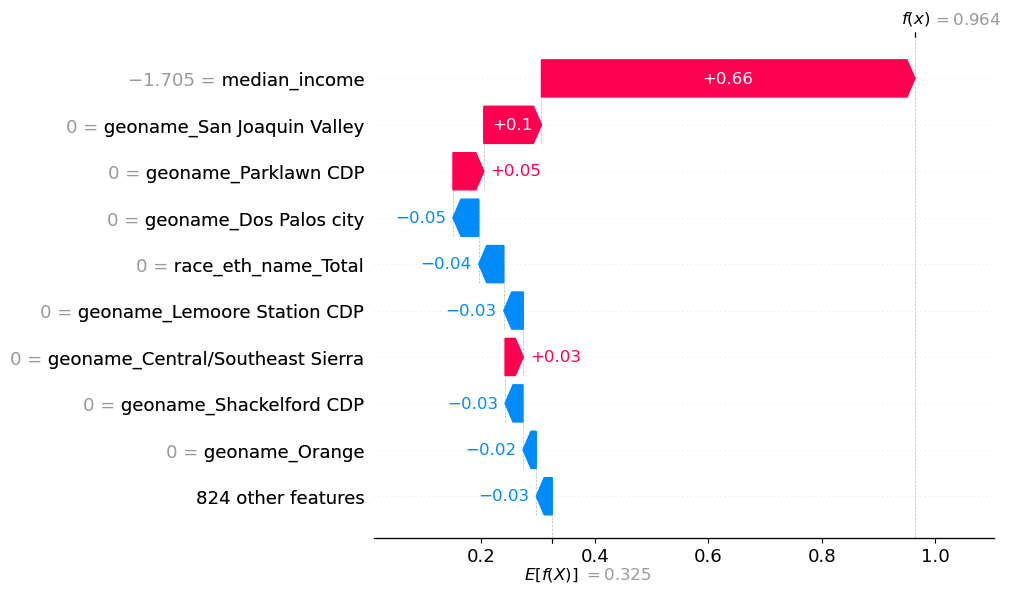

In [38]:
# what is on class notes
exp = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value,  # Scalar value
    data=X_train_dense_df.values,
    feature_names=final_feature_names
)

idx = 0
shap.plots.waterfall(exp[idx])

In [52]:
explainer.expected_value

10.478549

In [11]:
# Force plot for the first prediction
shap.force_plot(
    explainer.expected_value,  # baseline prediction (average of all predictions output)
    exp.values[0],  # SHAP values for the first prediction
    # each feature contributes negatively to the base value
    exp.data[0],  # Feature values for the first prediction
    # actual values of the features for this instance
    feature_names=exp.feature_names
)


Interpretation: `affordability_per_person` contributes -1.632, pushing the prediction lower than the average. `affordability_ratio` contributes -1.496, also pulling the prediction lower. Note that I had to take the log of price so in regular terms it is $35544.79 rather than 10.47 as the baseline

In [53]:
np.exp(10.478549)

35544.79460865981

# Anomaly Detection

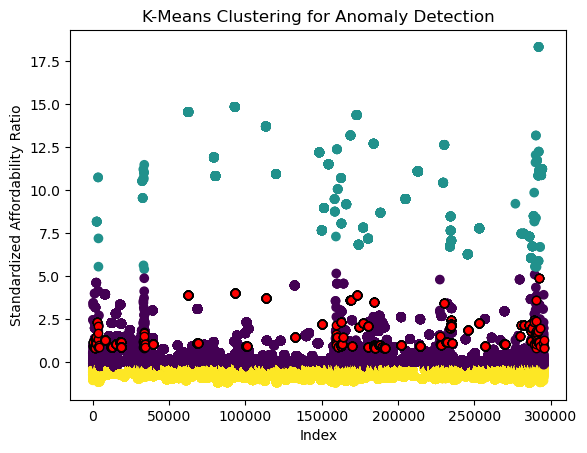

In [42]:
# anomaly detection on income with K Means

cluster = df[['affordability_ratio']]
# standardize 
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster)

# fit K Means
kmeans = KMeans(n_clusters=3, random_state = 42)
df['affordability_cluster'] = kmeans.fit_predict(cluster_scaled)
# distances to centroid
distances = np.abs(cluster_scaled - kmeans.cluster_centers_[df['affordability_cluster']])
df['afford_dist_centroid'] = distances

# set threshold
threshold = np.percentile(df['afford_dist_centroid'], 99) # capture top 1% of anomalies

# label anomalies
df['is_anomaly'] = df['afford_dist_centroid'] > threshold

# get anomalies
anomalies = df[df['is_anomaly']]

# visualize anomalies
plt.scatter(df.index, cluster_scaled, c=df['affordability_cluster'], cmap='viridis', label='Clusters')

plt.scatter(df[df['is_anomaly']].index, df[df['is_anomaly']]['affordability_ratio'], color='red', label='Anomalies', edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Standardized Affordability Ratio')
plt.title('K-Means Clustering for Anomaly Detection')
#plt.legend()
plt.show()

/var/folders/8f/l9_yqvn54_ldh6kclbdcgvfh0000gn/T/ipykernel_33034/3271351296.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_here['cluster'] = kmeans.fit_predict(X)


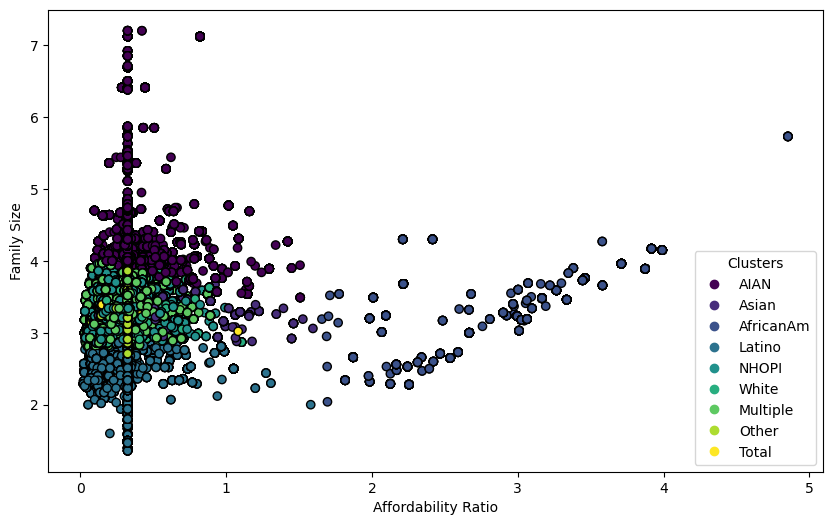

In [57]:
# anomaly detection on income, family size, race with K Means
features = df[['affordability_ratio','ave_fam_size', 'race_eth_name']]

df_here = df.dropna(subset=['affordability_ratio','ave_fam_size', 'race_eth_name'])  # Drop rows with missing values

# preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['affordability_ratio', 'ave_fam_size']),  # Scale numeric features
        ('cat', OneHotEncoder(), ['race_eth_name'])  # Encode categorical features
    ]
)

X = preprocessor.fit_transform(df_here)

# fit K Means
n_clusters = df['race_eth_name'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
df_here['cluster'] = kmeans.fit_predict(X)


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x = df_here['affordability_ratio'],
    y= df_here['ave_fam_size'],
    c=df_here['cluster'],  # Color by cluster
    cmap='viridis',
    edgecolor='k'
)
plt.xlabel('Affordability Ratio')
plt.ylabel('Family Size')
handles, _ = scatter.legend_elements()
legend_labels = df['race_eth_name'].unique()
plt.legend(handles, legend_labels, title="Clusters")

In [61]:
# Analyze centroids
#print(kmeans.cluster_centers_)

silhouette = silhouette_score(X, df_here['cluster'])
print(f'Silhouette Score: {silhouette}')

[[ 1.38097589e-01  1.70889526e+00  1.35053955e-01  1.21593058e-01
   1.26098565e-01  6.87506953e-02  1.34914896e-01  1.14806986e-01
   1.31577484e-01  5.28145511e-02  1.14389810e-01]
 [-1.44802406e-01 -1.22304566e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.83778478e+00  2.31768032e-01  3.70370370e-02  1.51083484e-01
   7.70525771e-02  2.90814124e-01  5.68937236e-02  1.20003453e-02
   1.16118449e-02  2.36898904e-01  1.26607960e-01]
 [ 1.49655132e-01  1.19822548e-01  1.90858719e-01  1.63038438e-01
   1.56326796e-01  0.00000000e+00  1.70387629e-01  0.00000000e+00
   1.95912737e-01  0.00000000e+00  1.23475680e-01]
 [ 1.96162425e-01 -1.15778961e+00  1.48732394e-01  1.35343828e-01
   1.25799503e-01  6.06959403e-02  1.41143331e-01  6.08450704e-02
   1.48931234e-01  7.09527755e-02  1.07555924e-01]
 [ 1.64647067e-01 -7.63491533e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  

PCA

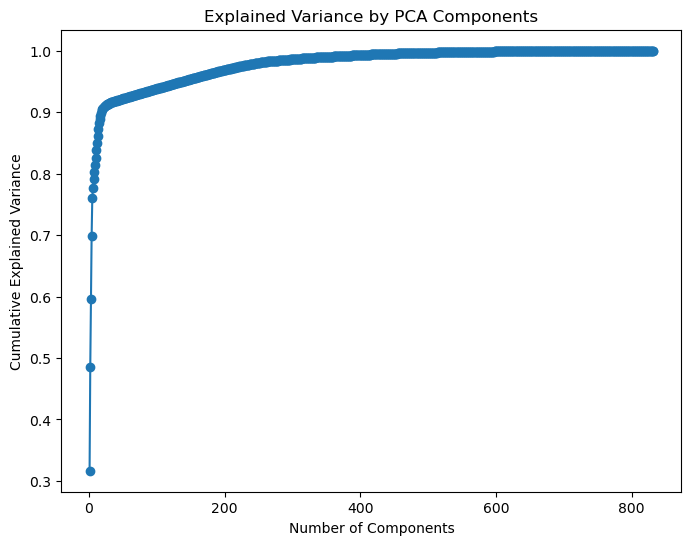

Number of components to retain 95% variance: 138


In [17]:
# using explained variance ratio to choose n_components
pca = PCA()
pca.fit(X_train_processed)
# plot cumulative variance explained by the components to visualize how much info each component adds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()
# set threshold to see how much variance to retain and find number of components needed to achieve that
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components to retain 95% variance: {n_components}")


In [ ]:
pca_start = time.time()
pca = PCA(n_components = n_components) # on train to avoid data leakage
## pca analyzes structure of training data and finds principle components (linear combinations of original features that maximize variance)
X_train_pc = pca.fit_transform(X_train_processed.toarray()) # project training data into lower-dimension
X_test_pc = pca.transform(X_test_processed)  # now this can be used for an improved model
pca_end = time.time()
print("PCA time (min): ", (pca_end-pca_start)/60)

PCA time (min):  0.1889883319536845


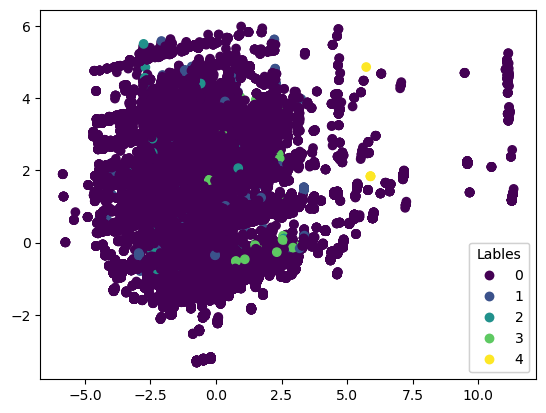

In [51]:
# plot first two pc
pc1 = X_train_pc[:,0]
pc2 = X_train_pc[:,1]
labels = y_train.astype(int)
fig, ax = plt.subplots()
scatter = ax.scatter(pc1, pc2, c=labels)

legend = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Lables")
ax.add_artist(legend)

In [52]:
# Calculate the loadings
# (relative importance of the original features to the principal components)
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
loadings = eigenvectors.T * np.sqrt(eigenvalues)

In [53]:
pca.explained_variance_ratio_.sum() # makes sense because that was my threshold

0.9501825495667494

# Improved XGBoost 

In [54]:
model = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0,
    random_state=42  
)

model.fit(X_train_pc, y_train)
y_pred_pc = model.predict(X_test_pc)

mse = root_mean_squared_error(y_test, y_pred_pc)
print(f'Test rMSE: {mse}')

Test rMSE: 0.020189788543501622


## UMAP

In [56]:
umap_start = time.time()
um = umap.UMAP(n_components=2, n_neighbors=15).fit_transform(X_train_processed)  
# n_neighbors might need to be adjusted to improve connectivity
umap_end = time.time()
print("UMAP time (min): ", (umap_end-umap_start)/60)

UMAP time (min):  5.224555611610413


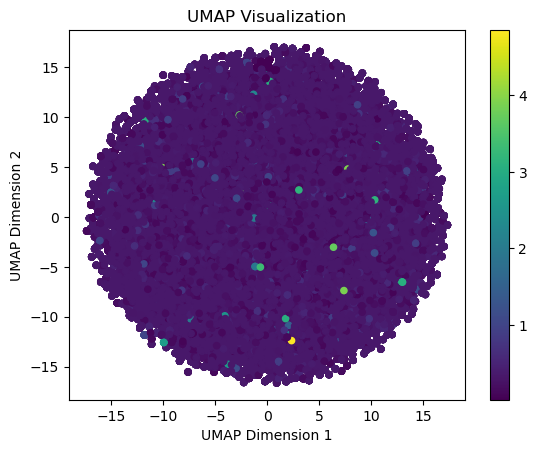

In [22]:
plt.scatter(um[:, 0], um[:, 1], c=y_train, cmap='viridis', s=20)
plt.colorbar()
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization')
plt.show()